## Analysis of Covid_19 cases and deaths

The Covid-19 pandemic is the current ongoing pandemic caused by **severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2).** The virus is mainly transmitted through droplets generated when an infected person coughs, sneezes, or exhales. As of today, there is no specific treatment of covid-10, and no vaccine protects agains SARS-CoV-2. Since its original outbreak in Wuhan, China, this virus continues to spread leading to many reported cases and deaths around the world. 

**This objective of this project is to spotlight the confirmed cases of infections and deaths caused by this virus around the globe.**

The public data used for analysis comes from **[European Center for Disease Prevention and Control](https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide)**

### Library Imports 

In [1]:
#necessary imports for data collection, cleaning, and visualization
import requests,json
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio

#import for country code
import country_converter as coco
import pycountry

#additional imports
import warnings
import calendar
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)
from IPython.display import HTML
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
init_notebook_mode(connected=True)
chart_studio.tools.set_credentials_file(username = 'martloni', api_key = 'EaOKn44v5NzlIEjgNQNZ') #set credentials for plotly account

## Obtain Data

In [2]:
#Get daily number of new reported cases of covid19 by country worldwide
response = json.loads(requests.get("https://opendata.ecdc.europa.eu/covid19/casedistribution/json/").text)

In [3]:
print(type(response))

<class 'dict'>


In [4]:
print(response.keys())

dict_keys(['records'])


In [5]:
print(len(response['records']))

46435


In [6]:
#load dataframe
data = pd.DataFrame(response['records'])

In [7]:
pd.set_option('display.max_columns', 85)
pd.set_option('display.max_colwidth', None)

In [8]:
#check the first 10 rows
data.head(10)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,02/10/2020,02,10,2020,17,0,Afghanistan,AF,AFG,38041757.0,Asia,1.08564912
1,01/10/2020,01,10,2020,14,0,Afghanistan,AF,AFG,38041757.0,Asia,1.04096138
2,30/09/2020,30,09,2020,15,2,Afghanistan,AF,AFG,38041757.0,Asia,1.04884745
3,29/09/2020,29,09,2020,12,3,Afghanistan,AF,AFG,38041757.0,Asia,1.11456471
4,28/09/2020,28,09,2020,0,0,Afghanistan,AF,AFG,38041757.0,Asia,1.34326078
5,27/09/2020,27,09,2020,35,0,Afghanistan,AF,AFG,38041757.0,Asia,1.54041255
6,26/09/2020,26,09,2020,6,2,Afghanistan,AF,AFG,38041757.0,Asia,1.54041255
7,25/09/2020,25,09,2020,16,0,Afghanistan,AF,AFG,38041757.0,Asia,1.61401588
8,24/09/2020,24,09,2020,25,5,Afghanistan,AF,AFG,38041757.0,Asia,1.64556017
9,23/09/2020,23,09,2020,71,2,Afghanistan,AF,AFG,38041757.0,Asia,1.64293148


In [9]:
data.columns

Index(['dateRep', 'day', 'month', 'year', 'cases', 'deaths',
       'countriesAndTerritories', 'geoId', 'countryterritoryCode',
       'popData2019', 'continentExp',
       'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'],
      dtype='object')

## Data Cleaning

In [10]:
#change to datetime format
data['Date'] = pd.to_datetime(data['dateRep'], format = '%d/%m/%Y')

In [11]:
#check if there is any date greater than today's dated
data[data['Date'] >  pd.to_datetime('today')]

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,Date


In [12]:
#check column type
data['Date'].dtype.name

'datetime64[ns]'

In [13]:
#check for unique month column
data['Date'].dt.month.unique()

array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1, 12])

In [14]:
# #current date
data['Date'].head()

0   2020-10-02
1   2020-10-01
2   2020-09-30
3   2020-09-29
4   2020-09-28
Name: Date, dtype: datetime64[ns]

In [15]:
#Get shape of data
data.shape

(46435, 13)

In [16]:
#quick info on the data 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46435 entries, 0 to 46434
Data columns (total 13 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   dateRep                                                     46435 non-null  object        
 1   day                                                         46435 non-null  object        
 2   month                                                       46435 non-null  object        
 3   year                                                        46435 non-null  object        
 4   cases                                                       46435 non-null  int64         
 5   deaths                                                      46435 non-null  int64         
 6   countriesAndTerritories                                     46435 non-null  object        
 7   geoId                 

In [17]:
#numeric data description: cases, death, country_population
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cases,46435.0,7.397592e+02,4.549351e+03,-8261.0,0.0,10.0,162.0,9.789400e+04
deaths,46435.0,2.204966e+01,1.267004e+02,-1918.0,0.0,0.0,3.0,4.928000e+03
popData2019,46371.0,4.250869e+07,1.569656e+08,815.0,1355982.0,8082359.0,28608715.0,1.433784e+09


In [18]:
#checking for number of uniqe territories, and country code
data[['countriesAndTerritories', 'geoId', 'countryterritoryCode', 'continentExp']].nunique()

countriesAndTerritories    210
geoId                      210
countryterritoryCode       209
continentExp                 6
dtype: int64

## Exploratory Data analysis

***

### Global reported number of cases and deaths till date

In [19]:
#Global cases and death, with mortality rate of covid 19
global_df = pd.DataFrame(data[['cases', 'deaths']].sum()).transpose()
global_df['Mortality rate (per 100)'] = np.round(100*global_df["deaths"]/global_df["cases"],2)
global_df = global_df.rename({0: 'Global'})
global_df.style.background_gradient(cmap='RdYlBu',axis=1).format("{:.2f}").format("{:.0f}",subset=["cases","deaths"])

,cases,deaths,Mortality rate (per 100)
Global,34350717,1023876,2.98


### Covid 19 **cases** in each continent

Text(0, 0.5, 'Total number of people with confirmed cases/Death (in million)')

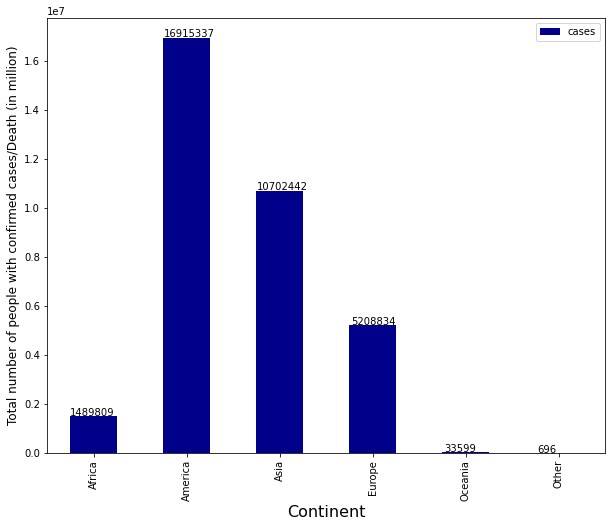

In [20]:
cases_and_death_in_each_continent = data.groupby('continentExp')[['cases']].sum() #Get total number of cases per continent
ax = cases_and_death_in_each_continent[['cases']].plot(kind='bar', figsize = (10, 8), color = 'darkblue') #bar plot
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005)) #for annotating the bars
plt.xlabel('Continent', fontsize = 16)
plt.ylabel('Total number of people with confirmed cases/Death (in million)', fontsize = 12)

### Covid 19 **death** in each continent

In [21]:
death_and_cases_per_continent = data.groupby('continentExp')['cases', 'deaths'].sum()

In [22]:
death_and_cases_per_continent['Mortality Rate (per 100)'] = np.round(100 * death_and_cases_per_continent['deaths']/death_and_cases_per_continent['cases'], 2) #calculating mortality rate 

In [23]:
death_and_cases_per_continent.sort_values('cases', ascending = False).style.background_gradient(cmap='Blues', subset=['cases'])\
                        .background_gradient(cmap='Reds',subset=["deaths"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])\


,cases,deaths,Mortality Rate (per 100)
continentExp,,,
America,16915337,566374,3.350000
Asia,10702442,195327,1.830000
Europe,5208834,225102,4.320000
Africa,1489809,36086,2.420000
Oceania,33599,980,2.920000
Other,696,7,1.010000


Text(0.5, 1.0, 'Total deaths in each continent')

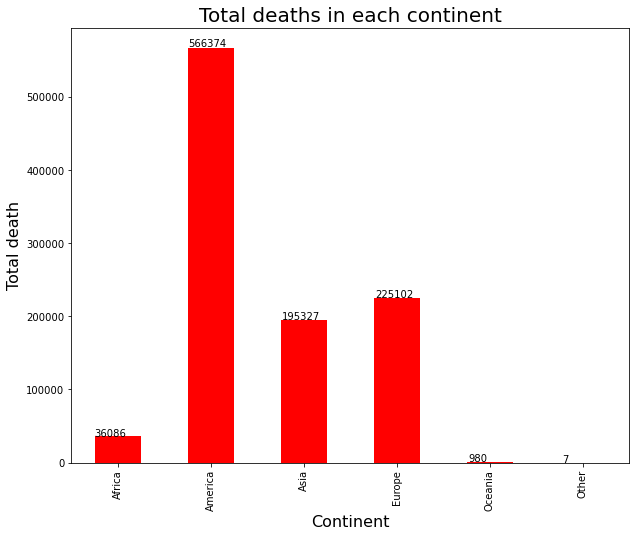

In [24]:
#check for number of de
plt.figure(figsize=(10, 8))
ax2 = data.groupby('continentExp')['deaths'].sum().plot(kind='bar', color = 'red') #grouby continent, calculate total deaths and plot bar
for p2 in ax2.patches:
    ax2.annotate(str(p2.get_height()), (p2.get_x() * 1.005, p2.get_height() * 1.005))
plt.xlabel('Continent', fontsize = 16)
plt.ylabel('Total death', fontsize = 16)
plt.title('Total deaths in each continent', fontsize=20)

##### The America continent has the total number of death

### Trend of covid19 death trend in each continent

In [25]:
#convert initial columns of date, year, and month to datetime object
data['day'] = data['Date'].dt.day
data['month'] = data['Date'].dt.month
data['year'] = data['Date'].dt.year

In [26]:
data['month'] = data['month'].apply(lambda x: calendar.month_abbr[x]) #convert to month name

In [27]:
#check data type
data.dtypes

dateRep                                                               object
day                                                                    int64
month                                                                 object
year                                                                   int64
cases                                                                  int64
deaths                                                                 int64
countriesAndTerritories                                               object
geoId                                                                 object
countryterritoryCode                                                  object
popData2019                                                          float64
continentExp                                                          object
Cumulative_number_for_14_days_of_COVID-19_cases_per_100000            object
Date                                                          datetime64[ns]

In [28]:
# #pivot table to get the number of deaths in each month relative to each continent
# deaths_per_month_per_continent = pd.pivot_table(data = data, values = 'deaths', index = 'month', columns = 'continentExp', fill_value=0, aggfunc = 'sum')

In [29]:
deaths_per_month_per_continent = pd.pivot_table(data = data, values = 'deaths', index = 'month', columns = 'continentExp', fill_value=0, aggfunc = 'sum')

In [30]:
#rearrange index column based on the appearance of covid
deaths_per_month_per_continent = deaths_per_month_per_continent.reindex(['Dec', "Jan", "Feb", "Mar", 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])

In [31]:
deaths_per_month_per_continent.style.background_gradient(cmap='Set1')

continentExp,Africa,America,Asia,Europe,Oceania,Other
month,,,,,,
Dec,0,0,0,0,0,0
Jan,0,0,213,0,0,0
Feb,0,0,2679,23,0,6
Mar,166,3687,3990,27933,21,1
Apr,1425,70904,11321,105431,95,0
May,2480,86923,11862,38869,15,0
Jun,5807,87158,25129,15982,2,0
Jul,9433,106910,39033,10745,87,0
Aug,10274,112185,45643,10093,432,0


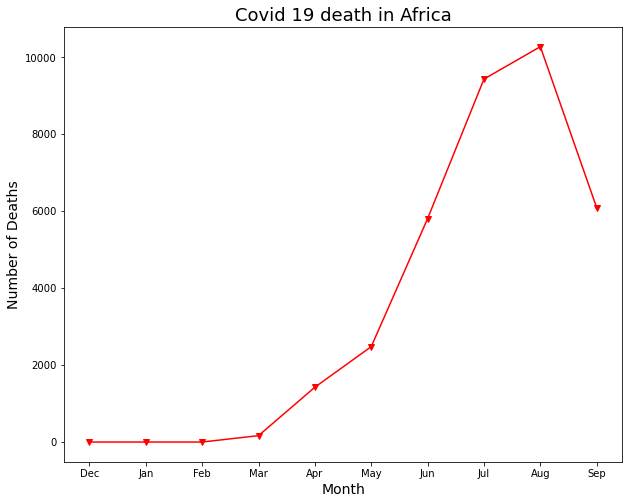

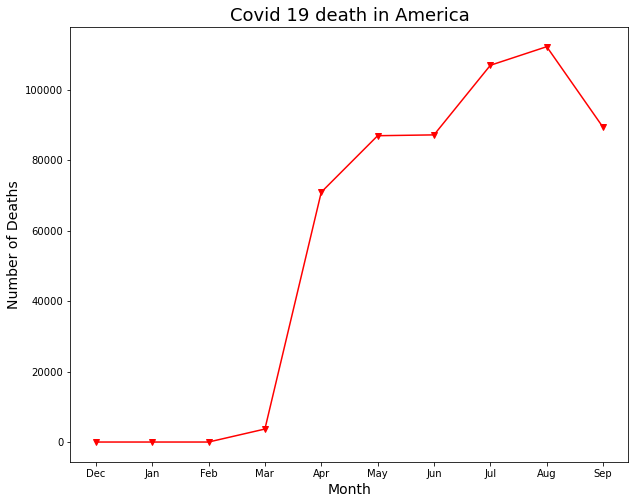

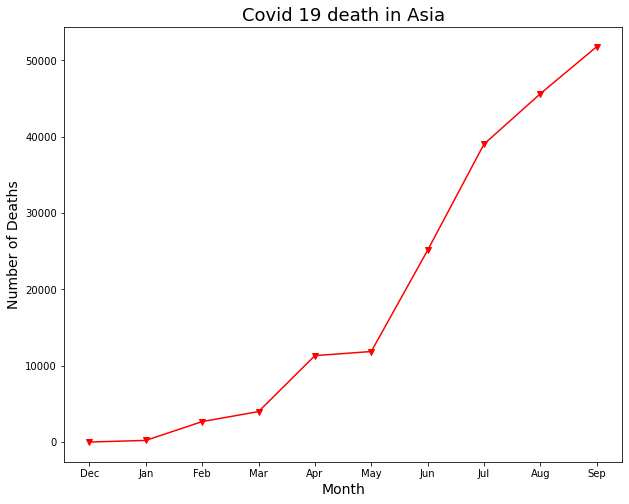

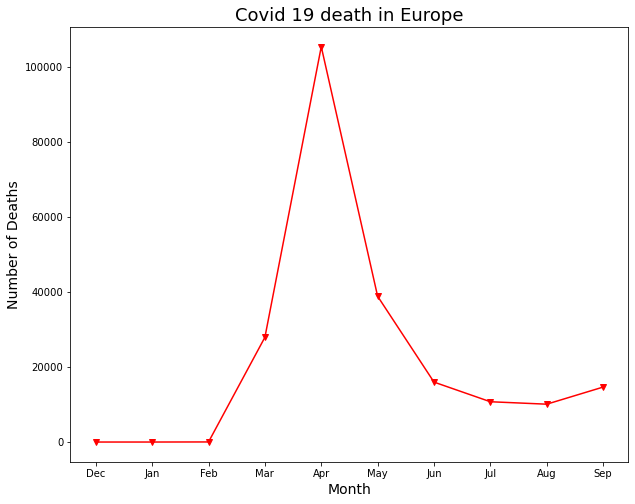

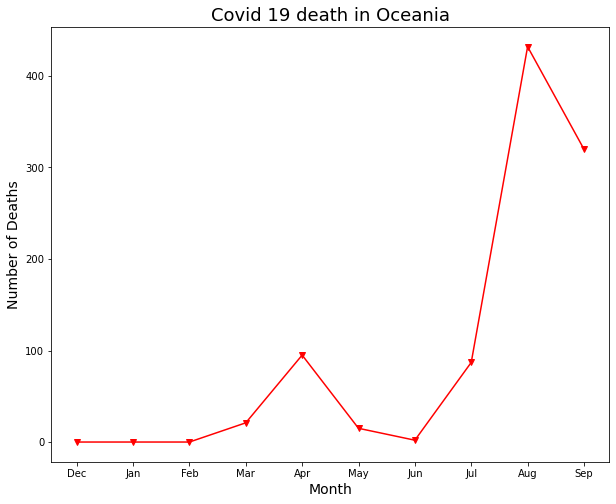

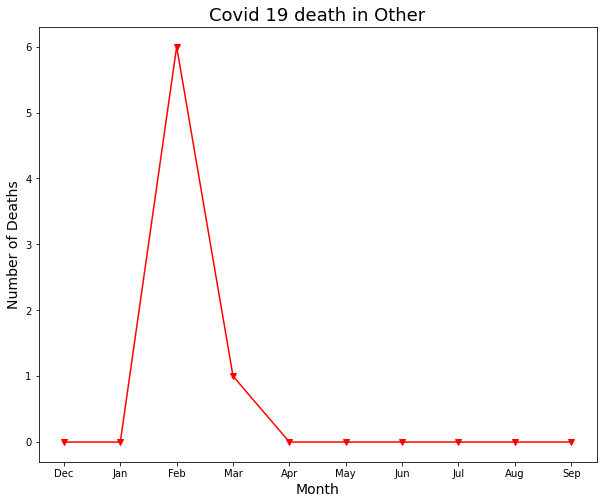

In [32]:
#plotting the number of death in each month relative per continent
for col in deaths_per_month_per_continent.columns: 
    fig, ax = plt.subplots(figsize = (10, 8))
    ax.plot(deaths_per_month_per_continent.index[:-1], deaths_per_month_per_continent[col][:-1], marker = 'v', color = 'r', ) #plot to the end of september
    ax.set_xlabel('Month', fontsize = 14)
    ax.set_ylabel('Number of Deaths', fontsize = 14)
    ax.set_title('Covid 19 death in '+str(col), fontsize = 18)

### Country wide reported cases

In [33]:
#Substract a week backwards
data['Date'] = data['Date'] - pd.to_timedelta(7, unit = 'd')

In [35]:
data = data.rename(columns = {'countriesAndTerritories': 'Country'})

In [36]:
data['Country'] = data['Country'].replace({'Cape_Verde': 'Cabo Verde', 'Isle_of_Man':'Isle of Man', 'Saint_Lucia' : 'Saint Lucia', 'South_Korea': 'South Korea'})

In [37]:
data_grouped_by_country_and_date = data.groupby(['Country', 'continentExp', pd.Grouper(key = 'Date',
                freq = 'W-Mon')])['cases', 'deaths'].sum().reset_index().sort_values(['Country', 'Date'], ascending = [1,0]).reset_index()\
                .drop('index', axis = 1)

In [38]:
data_grouped_by_country_and_date.head()

,Country,continentExp,Date,cases,deaths
0,Afghanistan,Asia,2020-09-28,58,5
1,Afghanistan,Asia,2020-09-21,183,12
2,Afghanistan,Asia,2020-09-14,328,21
3,Afghanistan,Asia,2020-09-07,318,8
4,Afghanistan,Asia,2020-08-31,236,10


In [39]:
cases_and_deaths_in_each_country = data_grouped_by_country_and_date.groupby('Country')['cases', 'deaths'].sum()

In [40]:
#calculate mortality rate for each country
cases_and_deaths_in_each_country['Mortality Rate (per 100)'] = np.round(100 * cases_and_deaths_in_each_country['deaths']/cases_and_deaths_in_each_country['cases'], 2)

In [41]:
cases_and_deaths_in_each_country.sort_values('cases', ascending = False).style.background_gradient(cmap='Blues', subset=['cases'])\
                        .background_gradient(cmap='Reds',subset=["deaths"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])\


,cases,deaths,Mortality Rate (per 100)
Country,,,
United_States_of_America,7277814,207808,2.860000
India,6394068,99773,1.560000
Brazil,4847092,144680,2.980000
Russia,1185231,20891,1.760000
Colombia,835339,26196,3.140000
Peru,818297,32535,3.980000
Spain,778607,31973,4.110000
Argentina,764989,20288,2.650000
Mexico,748315,78078,10.430000


### Top 15 countries with confirmed cases and confirmed death

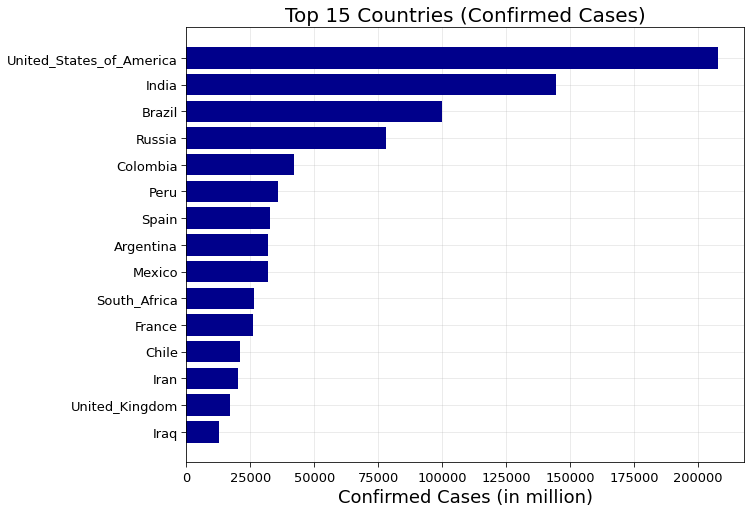

In [42]:
#number of confirmed cases per country
f = plt.figure(figsize=(10,8))
f.add_subplot(111)
plt.axes(axisbelow=True)
#plot first 15 countries based on the number of cases
plt.barh(cases_and_deaths_in_each_country.sort_values('cases', ascending=False).index[:15], cases_and_deaths_in_each_country.sort_values('deaths', ascending=False)['deaths'][:15], color="darkblue") 
plt.gca().invert_yaxis()
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases (in million)",fontsize=18)
plt.title("Top 15 Countries (Confirmed Cases)",fontsize=20)
plt.grid(alpha=0.3)

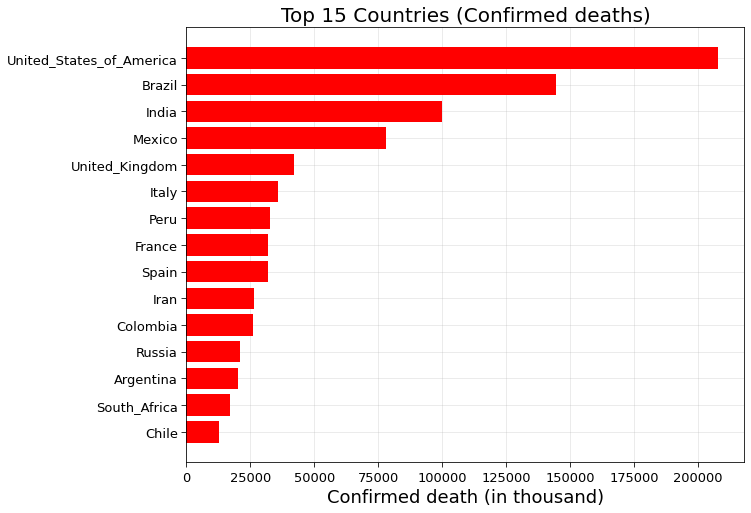

In [43]:
f = plt.figure(figsize=(10,8))
f.add_subplot(111)
plt.axes(axisbelow=True)
#plot first 15 countries based on the number of deaths
plt.barh(cases_and_deaths_in_each_country.sort_values('deaths', ascending=False).index[:15], cases_and_deaths_in_each_country.sort_values('deaths', ascending=False)['deaths'][:15], color="red")
plt.gca().invert_yaxis()
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed death (in thousand)",fontsize=18)
plt.title("Top 15 Countries (Confirmed deaths)",fontsize=20)
plt.grid(alpha=0.3)

### Correlation analysis for countries

In [44]:
cases_and_deaths_in_each_country.loc[:,:].corr().style.background_gradient(cmap='RdBu_r').format("{:.3f}")

,cases,deaths,Mortality Rate (per 100)
cases,1.000,0.932,0.043
deaths,0.932,1.000,0.164
Mortality Rate (per 100),0.043,0.164,1.000


### Correlation analysis for continent

In [45]:
death_and_cases_per_continent.corr().style.background_gradient(cmap='RdBu_r').format("{:.3f}")

,cases,deaths,Mortality Rate (per 100)
cases,1.000,0.948,0.295
deaths,0.948,1.000,0.485
Mortality Rate (per 100),0.295,0.485,1.000


### Confirmed Covid19 cases and deaths in each country (log scale)

In [46]:
#reset index first and rename the countriesandTerritories column to Country
cases_and_deaths_in_each_country = cases_and_deaths_in_each_country.reset_index()

In [47]:
cc = coco.CountryConverter()

In [49]:
#Generate country code
cases_and_deaths_in_each_country['Country_code'] = cases_and_deaths_in_each_country['Country'].apply(lambda x: cc.convert(names = x, to = 'ISO3'))

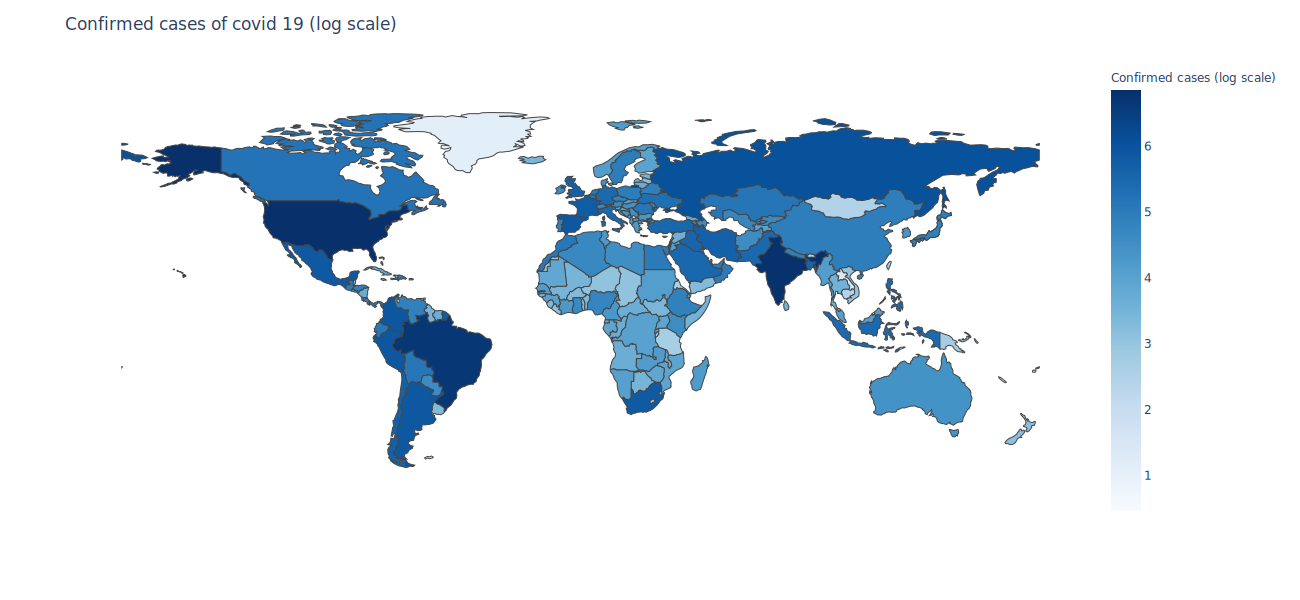

In [50]:
fig1 = px.choropleth(cases_and_deaths_in_each_country, locations=cases_and_deaths_in_each_country['Country_code'],
                    color=np.log10(cases_and_deaths_in_each_country["cases"]), # lifeExp is a column of gapminder
                    hover_name="Country", 
                    hover_data = ['cases'],
                    color_continuous_scale='Blues') # column to add to hover information
fig1.update_geos(fitbounds="locations", visible=False)
fig1.update_layout(title_text = 'Confirmed cases of covid 19 (log scale)', width=1300, height = 800)
fig1.update_coloraxes(colorbar_title = 'Confirmed cases (log scale)')
# a = py.plot(fig1, filename = 'covid_19_cases', auto_open = True)
# tls.get_embed(str(a)) #creates link for dynamic image
fig1.show(renderer = 'svg', width=1300, height = 600) #static imaged

<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://martloni.github.io/covid_19_cases_plotly/" height="525" width="100%"></iframe>

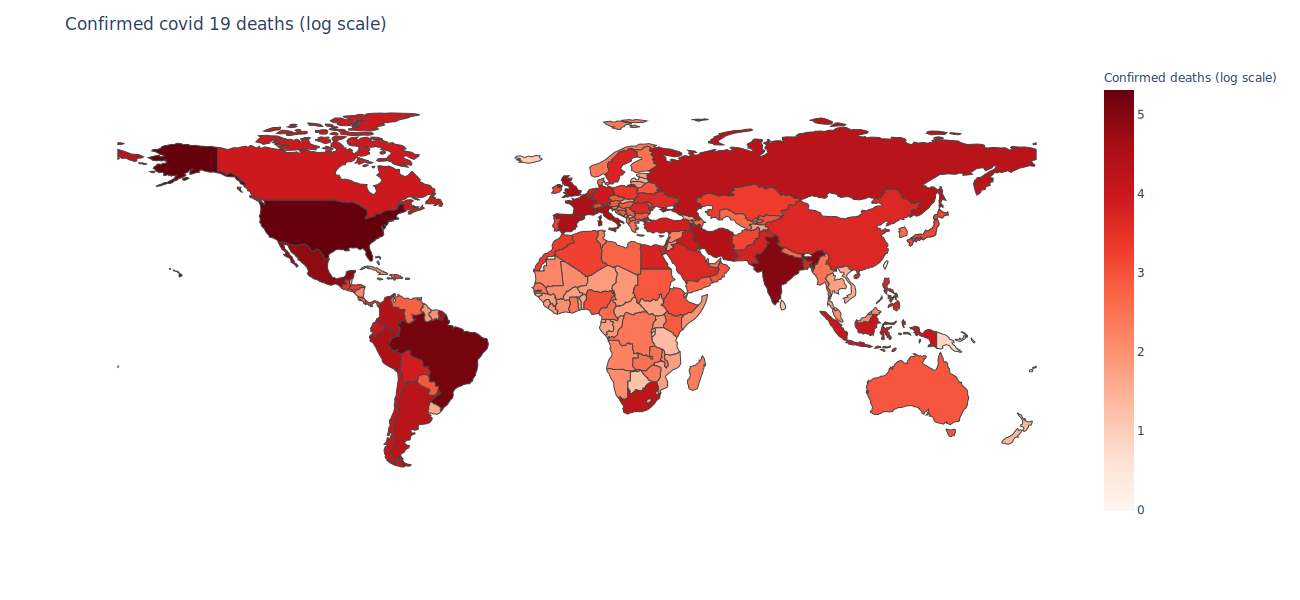

In [51]:
fig2 = px.choropleth(cases_and_deaths_in_each_country, locations=cases_and_deaths_in_each_country['Country_code'],
                    color=np.log10(cases_and_deaths_in_each_country["deaths"]), # lifeExp is a column of gapminder
                    hover_name="Country", 
                    hover_data = ['deaths'],
                    color_continuous_scale='Reds') # column to add to hover information
fig2.update_geos(fitbounds="locations", visible=False)
fig2.update_layout(title_text = 'Confirmed covid 19 deaths (log scale)',  width=1300, height = 800)
fig2.update_coloraxes(colorbar_title = 'Confirmed deaths (log scale)')
# b = py.plot(fig2, filename = 'covid_19_deaths', auto_open = True)
# tls.get_embed(str(b))
fig2.show(renderer = 'svg', width=1300, height = 600)

### Spread progression of Covid19

In [52]:
data_grouped_by_country_and_date.head()

,Country,continentExp,Date,cases,deaths
0,Afghanistan,Asia,2020-09-28,58,5
1,Afghanistan,Asia,2020-09-21,183,12
2,Afghanistan,Asia,2020-09-14,328,21
3,Afghanistan,Asia,2020-09-07,318,8
4,Afghanistan,Asia,2020-08-31,236,10


In [53]:
data_grouped_with_cummulative_sum =data_grouped_by_country_and_date.groupby(['Country', 'continentExp', 'Date'])['cases', 'deaths']\
        .sum().groupby(level = 0).cumsum().reset_index()\
        .sort_values(['Country', 'Date'], ascending = [1, 0])

In [54]:
data_grouped_with_cummulative_sum['Country_code'] = data_grouped_with_cummulative_sum['Country'].apply(lambda x: cc.convert(names = x, to = 'ISO3') )

In [55]:
#remove rows with date greater than current date
data_grouped_with_cummulative_sum = data_grouped_with_cummulative_sum[data_grouped_with_cummulative_sum['Date'] < pd.to_datetime('today')]

In [56]:
data_grouped_with_cummulative_sum['Date'] = data_grouped_with_cummulative_sum['Date'].dt.strftime('%Y-%m-%d')

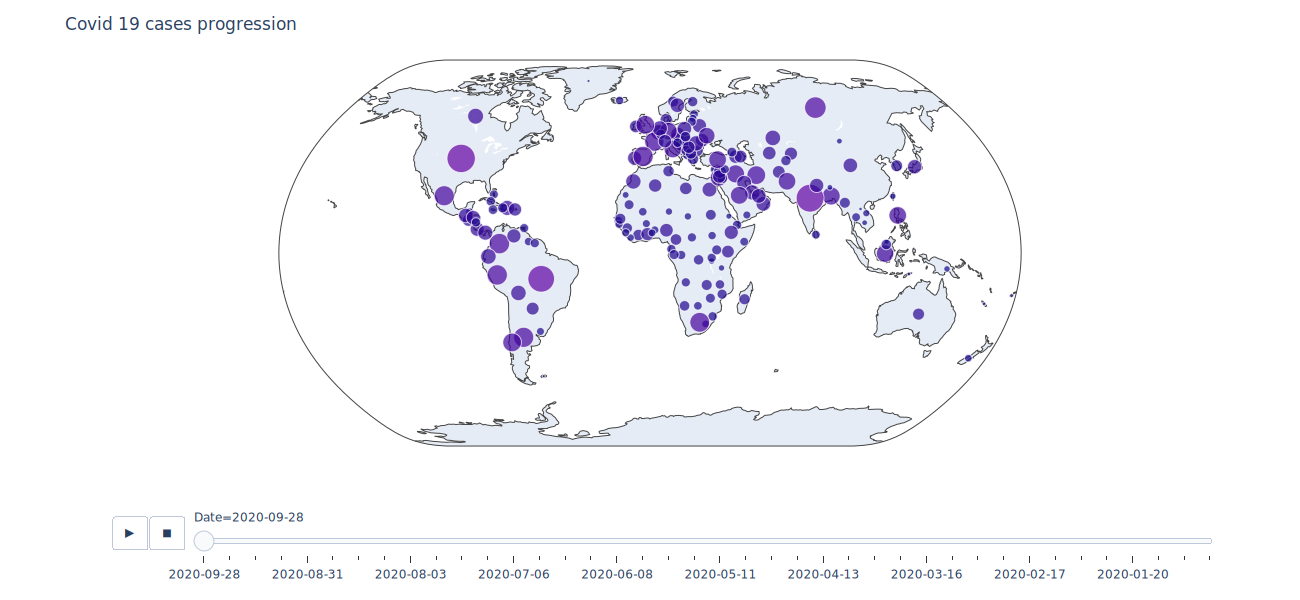

In [57]:
fig3 = px.scatter_geo(data_grouped_with_cummulative_sum, locations='Country_code', hover_name = 'Country', color=np.power(data_grouped_with_cummulative_sum['cases'], 0.2)-2,\
                 size = np.power(data_grouped_with_cummulative_sum["cases"]+1,0.3)-1, \
                 range_color= [0, max(np.power(data_grouped_with_cummulative_sum["cases"],0.3))], projection = 'natural earth', animation_frame = 'Date')
fig3.update_coloraxes(colorscale="plasma")
fig3.update_layout(title_text = 'Covid 19 cases progression', width=1000, height = 600)
fig3.update(layout_coloraxis_showscale = False)
# c = py.plot(fig3, filename = 'covid_19_cases_progression', auto_open = True)b
# tls.get_embed(str(c))
fig3.show(renderer = 'svg', width=1300, height = 600) #time reversed for the sake of static visualization